# Seismic Wave Tomography via Fast Marching - Regularization Demo

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we would like to demonstrate the capability of CoFI to easily
switch between different types of regularizations.

We will use `cofi` to run a seismic wave tomography example, in which
the forward calculation is based on the Fast Marching Fortran code by Nick
Rawlinson. The Fast Marching code is wrapped in package `espresso`.

We refer you to [fmm_tomography.ipynb](./fmm_tomography.ipynb) for further theretical
details.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
import espresso

### Understanding the inference problem

Before we starting working with `cofi`, let's get familiar with the problem itself.

Below is a plot of the true model and the paths generated from this model. As you can see,
there are two anomalies, one with lower velocity (red, top left) and the other with higher
velocity (blue, bottom right).

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.008911182496368759 0.0153757024856463 
 Mean travel time: 0.01085811731230709


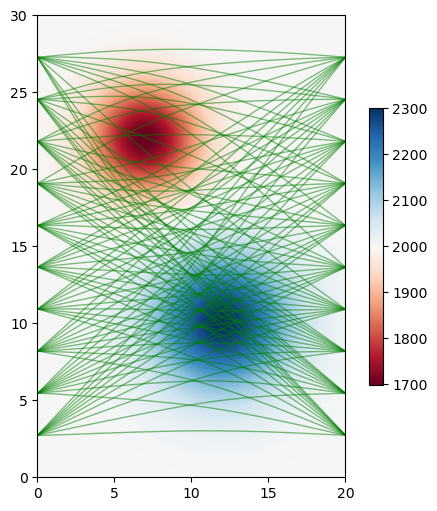

In [3]:
fmm = espresso.FmmTomography()

fmm.plot_model(fmm.good_model, with_paths=True);

In [4]:
pprint.pprint(fmm.metadata)

{'author_names': ['Nick Rawlinson', 'Malcolm Sambridge'],
 'citations': [('Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic '
                'wavefront tracking in 3-D heterogeneous media: applications '
                'with multiple data classes, Explor. Geophys., 37, 322-330.',
                ''),
               ('Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of '
                'active and passive source datasets for 3-D seismic structure '
                'with application to Tasmania, Geophys. Res. Lett., 33 L24313',
                '10.1029/2006GL028105'),
               ('de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A '
                'practical grid based method for tracking multiple refraction '
                'and reflection phases in 3D heterogeneous media, Geophys. J. '
                'Int., 167, 253-270',
                '')],
 'contact_email': 'Malcolm.Sambridge@anu.edu.au',
 'contact_name': 'Malcolm Sambridge',
 'linked_sites': [('Soft

## 1. Problem setup and utilities

In [5]:
# get problem information from  espresso FmmTomography
model_size = fmm.model_size         # number of model parameters
model_shape = fmm.model_shape       # 2D spatial grids
data_size = fmm.data_size           # number of data points
ref_start_slowness = fmm.starting_model

In [6]:
def objective_func(slowness, reg, sigma):
    ttimes = fmm.forward(slowness)
    residual = fmm.data - ttimes
    data_misfit = residual.T @ residual / sigma**2
    model_reg = reg(slowness)
    return  data_misfit + model_reg

def gradient(slowness, reg, sigma):
    ttimes, A = fmm.forward(slowness, return_jacobian=True)
    data_misfit_grad = -2 * A.T @ (fmm.data - ttimes) / sigma**2
    model_reg_grad = reg.gradient(slowness)
    return  data_misfit_grad + model_reg_grad

def hessian(slowness, reg, sigma):
    A = fmm.jacobian(slowness)
    data_misfit_hess = 2 * A.T @ A / sigma**2 
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

## 2. Invert with quadratic smoothing and damping regularization terms

### 2.1 Define BaseProblem

In [7]:
# define CoFI BaseProblem
fmm_problem_quadratic_reg = cofi.BaseProblem()
fmm_problem_quadratic_reg.set_initial_model(ref_start_slowness)

In [8]:
# add regularization: damping + smoothing
damping_factor = 50
smoothing_factor = 5e3
reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape, 
    weighting_matrix="damping", 
    reference_model=ref_start_slowness
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_damping + reg_smoothing

In [9]:
sigma =  0.00001                   # Noise is 1.0E-4 is ~5% of standard deviation of initial travel time residuals

fmm_problem_quadratic_reg.set_objective(objective_func, args=[reg, sigma])
fmm_problem_quadratic_reg.set_gradient(gradient, args=[reg, sigma])
fmm_problem_quadratic_reg.set_hessian(hessian, args=[reg, sigma])

### 2.2 Define InversionOptions

In [10]:
my_options = cofi.InversionOptions()

# cofi's own simple newton's matrix-based optimization solver
my_options.set_tool("cofi.simple_newton")
my_options.set_params(num_iterations=6, step_length=1, verbose=True)

### 2.3 Start an inversion

In [11]:
inv = cofi.Inversion(fmm_problem_quadratic_reg, my_options)
inv_result_quadratic_reg = inv.run()
inv_result_quadratic_reg.summary()

Iteration #0, objective function value: 110298.7001724638
Iteration #1, objective function value: 1787.0459655957825
Iteration #2, objective function value: 121.09918298452581
Iteration #3, objective function value: 5.805217146094518
Iteration #4, objective function value: 3.853291569236922
Iteration #5, objective function value: 1.6509714163979023
Summary for inversion result
SUCCESS
----------------------------
model: [0.00048363 0.0004817  0.00048005 ... 0.00050727 0.00050677 0.00050617]
num_iterations: 5
objective_val: 2.717895837439228
n_obj_evaluations: 6
n_grad_evaluations: 6
n_hess_evaluations: 6


### 2.4 Plotting

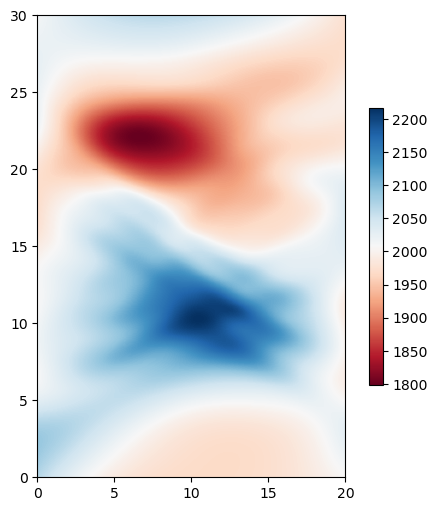

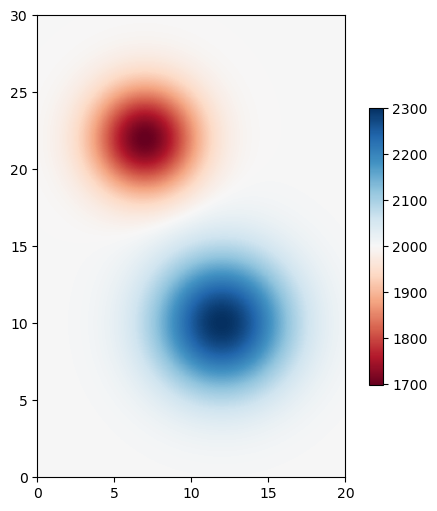

In [12]:
fmm.plot_model(inv_result_quadratic_reg.model);            # inverted model
fmm.plot_model(fmm.good_model);       # true model

---

## 3. Invert with Gaussian prior as regularization term

Instead of using a smoothing and damping regularization, in this section, we
use a model covariance matrix and prior model.

$\chi_{P}^{2}=\left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right)^T C_d^{-1} \left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right) + \left( \mathbf{m} - \mathbf{m}_p \right)^T C_p^{-1} \left( \mathbf{m} - \mathbf{m}_p \right)$

$\Delta \mathbf{m}= ({J}^T {C}_d^{-1} {J}+{C}_p^{-1})^{-1} ({J}^T{C}_d^{-1} (\mathbf{y}-\mathbf{f}(\mathbf{m}))+{C}_p^{-1}(\mathbf{m}_p-\mathbf{m}))$

We can use CoFI's utility module to help us generate a the Gaussian prior term.

### 3.1 Define BaseProblem

In [13]:
# define CoFI BaseProblem
fmm_problem_gaussian_prior = cofi.BaseProblem()
fmm_problem_gaussian_prior.set_initial_model(ref_start_slowness)

In [14]:
# add regularization: Gaussian prior
corrx = 3.0
corry = 3.0
sigma_slowness = 0.002
gaussian_prior = cofi.utils.GaussianPrior(
    model_covariance_inv=((corrx, corry), sigma_slowness),
    mean_model=ref_start_slowness.reshape(model_shape)
)

In [15]:
fmm_problem_gaussian_prior.set_objective(objective_func, args=[gaussian_prior, sigma])
fmm_problem_gaussian_prior.set_gradient(gradient, args=[gaussian_prior, sigma])
fmm_problem_gaussian_prior.set_hessian(hessian, args=[gaussian_prior, sigma])

### 3.2 Start an inversion

In [16]:
# reuse the previously defined InversionOptions object
inv = cofi.Inversion(fmm_problem_gaussian_prior, my_options)
inv_result_gaussian_prior = inv.run()
inv_result_gaussian_prior.summary()

Iteration #0, objective function value: 110298.7001724638
Iteration #1, objective function value: 2506.485369058785
Iteration #2, objective function value: 1024.9309152365788
Iteration #3, objective function value: 977.4811110047501
Iteration #4, objective function value: 976.6662653781225
Iteration #5, objective function value: 975.9998857900206
Summary for inversion result
SUCCESS
----------------------------
model: [0.00049665 0.00049542 0.00049382 ... 0.00050314 0.0005023  0.00050166]
num_iterations: 5
objective_val: 976.2098353866512
n_obj_evaluations: 6
n_grad_evaluations: 6
n_hess_evaluations: 6


### 3.3 Plotting

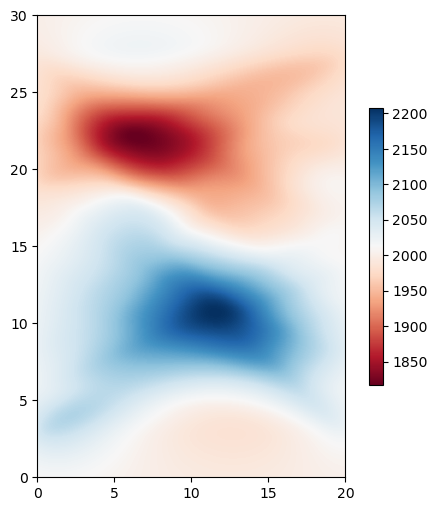

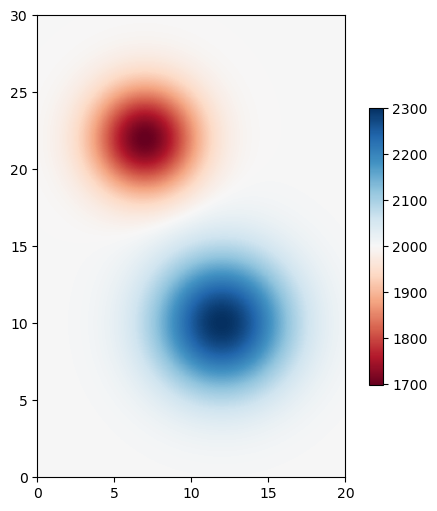

In [17]:
fmm.plot_model(inv_result_gaussian_prior.model);            # inverted model
fmm.plot_model(fmm.good_model);       # true model

## 4. Comparison and discussion

#TODO

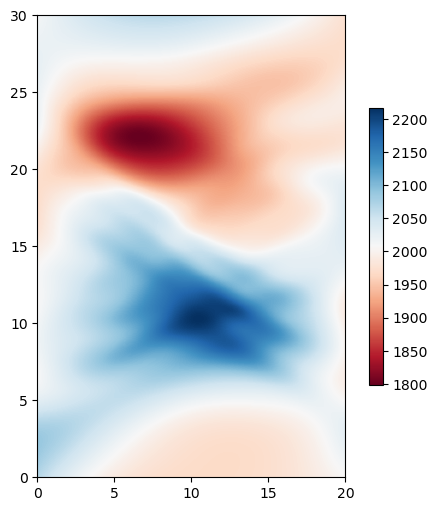

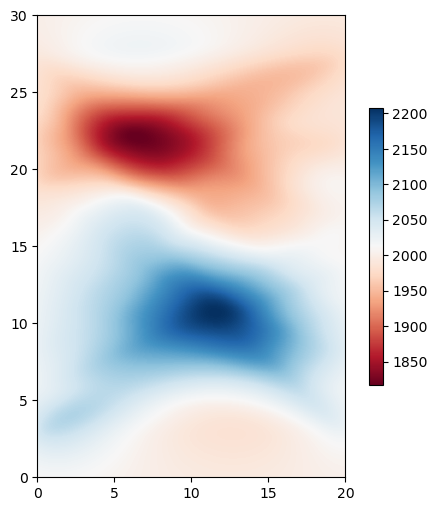

In [18]:
fmm.plot_model(inv_result_quadratic_reg.model);
fmm.plot_model(inv_result_gaussian_prior.model);

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [19]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.0
espresso 0.3.8
numpy 1.23.5
matplotlib 3.7.1
